In [ ]:
import os
from dotenv import load_dotenv

In [43]:
#Setting environment variables
# Load environment variables from .env file
load_dotenv('../.env')
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv('LANGSMITH_KEY')

In [44]:
from langchain.chat_models import init_chat_model

os.environ["GEMINI_API_KEY"] = os.getenv('GEMMA_KEY')

model = init_chat_model(
    "gemma-3-12b-it", # Use the specific model version you need
    model_provider="google_genai"
)

In [45]:
#Preprocess documents 
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [46]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

In [47]:
#Split fetched documents into smaller chunks for vector store 
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [48]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

# 2. Initialize the Vector Store with the embedding model
vectorstore = InMemoryVectorStore(embeddings)

# 3. Add your documents
# This step creates the embeddings and stores them in memory
vectorstore.add_documents(doc_splits)

# 4. Create your retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [49]:
#create a prebuilt retriever tool. The classic library they have written is now more deprecated and old
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [50]:
#test the tool
retriever_tool.invoke({"query": "types of reward hacking"})

'Why does Reward Hacking Exist?#\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nMost of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into practical mitigations, especially in the context of RLHF and LLMs, remains limited. I especially want to call out for more research efforts directed toward understanding and developing mitigation for reward hacking in the future. Hope I will be able to cover the mitigation part in a dedicated post soon.\nBackground#\nReward Function in RL#'

In [51]:
#Build generate query node
from langgraph.graph import MessagesState

#Build generate query node
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI

os.environ["QWEN3_API_KEY"] = os.getenv('QWEN3_KEY')

response_model = ChatOpenAI(
    model="qwen3",  # Specify a model available on OpenRouter
    api_key=os.environ["QWEN3_API_KEY"],
    base_url="https://ellm.nrp-nautilus.io/v1",
)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [52]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================



Hello! How can I assist you today? 😊


In [53]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (chatcmpl-tool-82cbe7c1358beb3f)
 Call ID: chatcmpl-tool-82cbe7c1358beb3f
  Args:
    query: types of reward hacking


In [54]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = ChatOpenAI(
    model="qwen3",  # Specify a model available on OpenRouter
    api_key=os.environ["QWEN3_API_KEY"],
    base_url="https://ellm.nrp-nautilus.io/v1",
)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [55]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [56]:
from langchain_core.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


response_model = init_chat_model(
    "gemma-3-4b-it", # Use the specific model version you need
    model_provider="google_genai"
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [57]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1].content)

Okay, here's my reasoning about the initial question and a formulated improvement:

**Reasoning about the Initial Question:**

The initial question is quite broad. “Types of reward hacking” is a specific topic within a larger area of AI ethics and alignment. It’s asking for a summary or categorization of different ways AI systems might be manipulated to receive rewards in ways that aren’t aligned with the intended goal.  It implies a desire to understand the *variety* of these behaviors, not just a single example.  It also suggests Lilian Weng has written about this topic.

**Improved Question:**

“Can you summarize the different categories of reward hacking strategies that Lilian Weng has identified, and provide examples of each?”

**Why this is an improvement:**

*   **Specificity:** It asks for a *summary* and *categories*, forcing a more structured response.
*   **Request for Examples:** Adding “and provide examples” ensures the answer isn’t just theoretical.
*   **Clearer Intent:*

In [58]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [59]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng identifies two types of reward hacking: environment or goal misspecification, and reward tampering. These categories describe how the reward signal is manipulated or misrepresented to the agent. Essentially, it’s about exploiting flaws in the reward system itself.


In [60]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

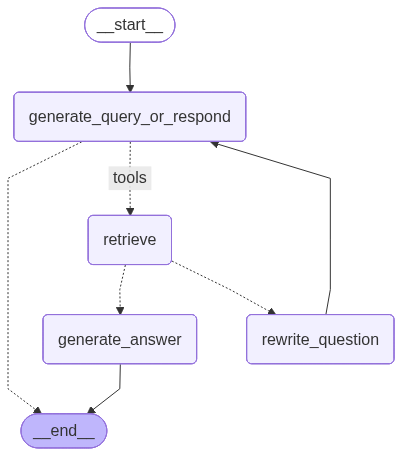

In [61]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

ChatGoogleGenerativeAIError: Error calling model 'gemma-3-4b-it' (INVALID_ARGUMENT): 400 INVALID_ARGUMENT. {'error': {'code': 400, 'message': 'Function calling is not enabled for models/gemma-3-4b-it', 'status': 'INVALID_ARGUMENT'}}